# Introduction

This Python notebook applies Facebook's Movement Range Maps dataset, originally intended for monitoring the effects of lockdowns on human movement during the COVID-19 pandemic, to a new use case: natural disasters.

Movement Range Maps is a dataset released by Facebook and made publicly available for several countries on the Humanitarian Data Exchange. The dataset provides daily datapoints since February 2020 on two metrics: (i) Relative change in the proportion of Bing tiles visited by Facebook users per day, and (ii) proportion of Facebook users staying in a single Bing tile all day.

# Imports

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import webbrowser  

from zipfile import ZipFile

# for plotting time series
from datetime import datetime
# registering converters for plotting datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# HDX Imports
from hdx.utilities.easy_logging import setup_logging
from hdx.hdx_configuration import Configuration
Configuration.create(hdx_site='prod', hdx_read_only=True,user_agent='WBG')
from hdx.data.dataset import Dataset
import os
import shutil

# Functions

In [3]:
def download_from_gadm(countries):
    for country in countries:
        url = f'https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_{country}_shp.zip'
        webbrowser.open(url, new=0, autoraise=True)    

In [4]:
def download_from_hdx():
    '''
    Function to download latest movement range maps from HDX.
    '''
    url, path = Dataset.get_resources(Dataset.read_from_hdx('movement-range-maps'))[1].download('data/')
    print('Resource URL %s downloaded to %s' % (url, path))
    return url,path


In [5]:
def unzip(filepath):
    # Create a ZipFile Object and load sample.zip in it
    with ZipFile(filepath, 'r') as zipObj:
       # Extract all the contents of zip file in current directory
       zipObj.extractall('data/')

In [6]:
# Reading in the data manually now but can automate with the download from HDX
def read_facebook_data(filepath):
    data = pd.read_csv(filepath,sep='\t')
    data['ds'] = pd.to_datetime(data['ds'])
    data['all_day_bing_tiles_visited_percent_change'] = data['all_day_bing_tiles_visited_relative_change']*100
    data['all_day_percent_single_tile_users'] = data['all_day_ratio_single_tile_users']*100
    return data

In [7]:
def find_affected(shapefile,custom=None):
    if custom is None:
        return select_affected_from_names(shapefile)
    else:
        return shapefile[shapefile.centroid.within(custom.geometry.squeeze())]


In [15]:
def select_affected_from_names(shapefile):
    col0 = []
    col1 = []
    col2 = []
    data = pd.DataFrame()
    for n in range(3):
        col_names = [i for i in shapefile.columns if (i[-1]==str(n)) & ('NAME' in i) &('NL_NAME' not in i) ]
        if 'VARNAME_' + str(n) in col_names:
            col = 'VARNAME_' + str(n)
        else:
            col = 'NAME_' + str(n)
        names = shapefile[col].sort_values().unique()
        dict_ = (dict(list(zip(range(len(names)),names))))

        if n==0:
            print('Was the whole country affected?')
            x = ''
            while (x != 'Y') & (x != 'N'):
                print('Enter Y or N.')
                x = input()

            if x == 'Y':
                data = shapefile
                print('Including whole country in analysis extent.\n')
                break

        elif n==1:
            print('\nSelect provinces that were affected. Separate with commas. Hit enter to skip provinces and move to cities/towns/municipalities.\n')
            print(dict_)
            print()
            x = input()
            if x != '':
                data = pd.concat([data,shapefile[shapefile[col].isin([dict_[int(i)] for i in x.split(',')])]])
                print('Selected provinces: ', [dict_[int(i)] for i in x.split(',')])
            elif x=='':
                print('No provinces selected.\n')

        elif n==2:
            y = 1
            while y!= '' :
                print('Hit enter to continue.')
                y = input() 

            print('\nSelect cities/towns/municipalities that were affected. Separate with commas.\n')
            print(dict_)
            print()
            x = input()
            if x != None:
                data = pd.concat([data,shapefile[shapefile[col].isin([dict_[int(i)] for i in x.split(',')])]])
                print('Selected cities/municipalities: ', [dict_[int(i)] for i in x.split(',')])

            elif x=='':
                print('No cities/towns/municipalities selected.\n')                
#                 data = shapefile

    return data

# Downloading and Reading data

Below, we download administrative shapefiles from the Database of Global Administrative Areas (GADM). GADM data is available at https://gadm.org/data.html. Facebook data is provided at administrative level 2, therefore we use ESRI Shapefile's with the `_2.shp` suffix. After downloading the data, make sure it is unzipped.

In [9]:
# download_from_gadm(['VNM','PHL']) #Uncomment if data not yet downloaded

In [10]:
gadm_vnm = gpd.read_file('data/boundaries/vietnam/gadm36_VNM_shp/gadm36_VNM_2.shp') # Filepath can be edited if data saved elsewhere
gadm_phl = gpd.read_file('data/boundaries/philippines/gadm36_PHL_shp/gadm36_PHL_2.shp')

In [13]:
url, path = download_from_hdx() #Download data from HDX, save in 'url' variable
unzip(path) #Unzip data downloaded to path
data = read_facebook_data('data/movement-range-'+path[-14:-4]+'.txt') # Pass relevant filepath

Resource URL https://data.humdata.org/dataset/c3429f0e-651b-4788-bb2f-4adbf222c90e/resource/55a51014-0d27-49ae-bf92-c82a570c2c6c/download/movement-range-data-2021-01-09.zip downloaded to data/movement-range-data-2021-01-09.zip


/Users/mahamfaisalkhan/anaconda3/envs/wbg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [33]:
# OPTION:
# EITHER pass in a custom shapefile disaster extent
# vnm_affected = find_affected(gadm_vnm)

# OR read in extents of interest
vnm_custom = gpd.read_file('data/disaster_extents/vietnam_flooding/vnm_extent.shp')
vnm_affected = find_affected(gadm_vnm,vnm_custom)

In [22]:
# OPTION:
# EITHER pass in a custom shapefile disaster extent
# phl_affected = find_affected(gadm_phl)

# OR read in extents of interest
phl_custom = gpd.read_file('data/disaster_extents/philippines_flooding/phl_extent.shp')
phl_affected = find_affected(gadm_phl,phl_custom)

# Plotting disaster event

In [24]:
color = 'lightgrey'
alpha = 0.1
fontsize=9

## Vietnam

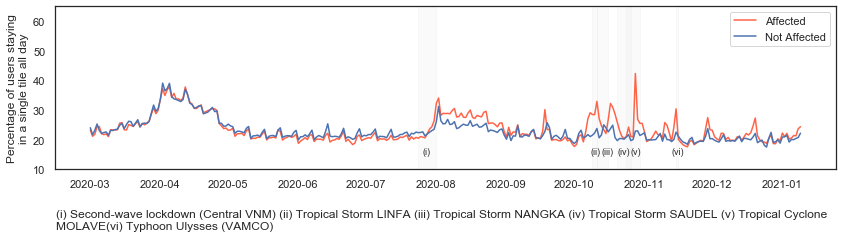

In [34]:
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(vnm_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(vnm_affected['GID_2'].unique())&(data['country']=='VNM')].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',ax=ax)
plt.axvspan(datetime(2020,10,9),datetime(2020,10,11),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,11),datetime(2020,10,16),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,20),datetime(2020,10,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,24),datetime(2020,10,30),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,7,24),datetime(2020,8,1),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,15),datetime(2020,11,16),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,7,26),15,'(i)',fontsize=fontsize) # Second lockdown
plt.text(datetime(2020,10,8),15,'(ii)',fontsize=fontsize) #
plt.text(datetime(2020,10,13),15,'(iii)',fontsize=fontsize) #
plt.text(datetime(2020,10,20),15,'(iv)',fontsize=fontsize) #
plt.text(datetime(2020,10,26),15,'(v)',fontsize=fontsize) # Molave
plt.text(datetime(2020,11,13),15,'(vi)',fontsize=fontsize) # Ulysses
plt.text(datetime(2020,2,15),-10,'(i) Second-wave lockdown (Central VNM) (ii) Tropical Storm LINFA (iii) Tropical Storm NANGKA (iv) Tropical Storm SAUDEL (v) Tropical Cyclone\nMOLAVE(vi) Typhoon Ulysses (VAMCO)',ha='left')

plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Percentage of users staying\nin a single tile all day')
plt.ylim([10,65])
plt.show()

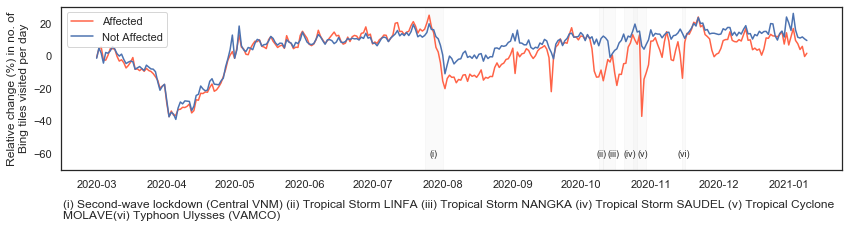

In [26]:
# Vietnam mobility
fig, ax = plt.subplots(figsize=(14,3))
label_height = -62

sns.lineplot(data=data[data['polygon_id'].isin(vnm_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(vnm_affected['GID_2'].unique())&(data['country']=='VNM')].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',ax=ax)
plt.axvspan(datetime(2020,10,9),datetime(2020,10,11),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,11),datetime(2020,10,16),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,20),datetime(2020,10,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,24),datetime(2020,10,30),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,7,24),datetime(2020,8,1),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,15),datetime(2020,11,16),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,7,26),label_height,'(i)',fontsize=fontsize)
plt.text(datetime(2020,10,8),label_height,'(ii)',fontsize=fontsize)
plt.text(datetime(2020,10,13),label_height,'(iii)',fontsize=fontsize)
plt.text(datetime(2020,10,20),label_height,'(iv)',fontsize=fontsize)
plt.text(datetime(2020,10,26),label_height,'(v)',fontsize=fontsize)
plt.text(datetime(2020,11,13),label_height,'(vi)',fontsize=fontsize)
plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Relative change (%) in no. of\nBing tiles visited per day')
plt.ylim([-70,30])
plt.text(datetime(2020,2,15),-100,'(i) Second-wave lockdown (Central VNM) (ii) Tropical Storm LINFA (iii) Tropical Storm NANGKA (iv) Tropical Storm SAUDEL (v) Tropical Cyclone\nMOLAVE(vi) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()


## Philippines

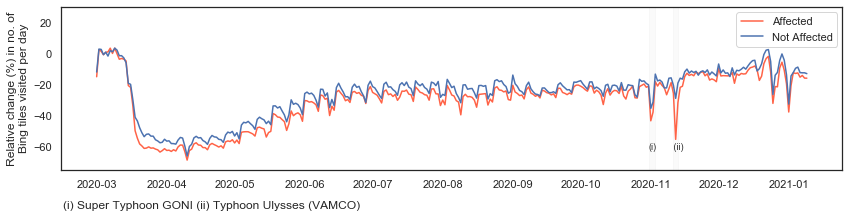

In [27]:
# Philippines mobility
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(phl_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(phl_affected['GID_2'].unique())&(data['country']=='PHL')].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',ax=ax)
plt.axvspan(datetime(2020,10,31),datetime(2020,11,3),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,11),datetime(2020,11,13),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,10,31),-62,'(i)',fontsize=fontsize)
plt.text(datetime(2020,11,10),-62,' (ii)',fontsize=fontsize)
plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylim([-75,30])
plt.ylabel('Relative change (%) in no. of\nBing tiles visited per day')
plt.text(datetime(2020,2,15),-100,'(i) Super Typhoon GONI (ii) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()

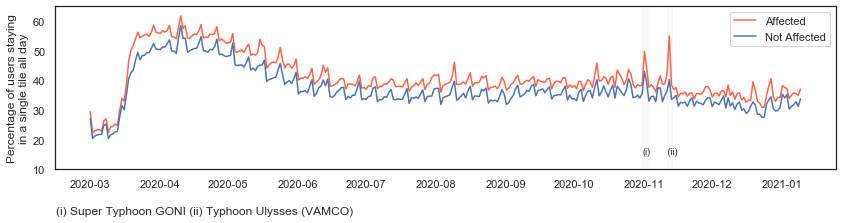

In [28]:
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(phl_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(phl_affected['GID_2'].unique())&(data['country']=='PHL')].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',ax=ax)
plt.axvspan(datetime(2020,10,31),datetime(2020,11,3),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,11),datetime(2020,11,13),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,10,31),15,'(i)',fontsize=fontsize)
plt.text(datetime(2020,11,10),15,' (ii)',fontsize=fontsize)
plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Percentage of users staying\nin a single tile all day')
plt.ylim([10,65])
plt.text(datetime(2020,2,15),-5,'(i) Super Typhoon GONI (ii) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()